PUIG

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
import pandas as pd
sys.path.append('/Users/luciamenendezfernandez/Desktop/TFM lucia/src/lag1_funciones')


In [8]:
# --- CONFIGURACIÓN INICIAL ---
import sys
import os

from preprocessing import cargar_datos
from features import crear_variables_lag_y_temporales
from model_training import dividir_train_test, definir_modelos, entrenar_y_evaluar_modelos
from visualization import graficar_predicciones

# --- PARÁMETROS ---
empresa = "PUIG"
ruta_datos = "/Users/luciamenendezfernandez/Desktop/TFM lucia/data/IBEX35_cotizaciones_20_Limpio.csv"

# --- 1. Cargar y preparar los datos ---
df_puig = cargar_datos(ruta_datos, empresa)

In [9]:
df_puig

,Precio_cierre
Fecha,
2024-05-03,24.500000
2024-05-06,25.500000
2024-05-07,26.360001
2024-05-08,26.400000
2024-05-09,25.760000
...,...
2025-03-26,16.110001
2025-03-27,16.275000
2025-03-28,16.520000


In [10]:
df_puig = df_puig.reset_index()
df_puig['Fecha'] = pd.to_datetime(df_puig['Fecha'], errors='coerce')


In [11]:
df_puig['Fecha'] = pd.to_datetime(df_puig['Fecha'], errors='coerce')

In [12]:
#Seleccionar solo las columnas necesarias y establecer el índice
df_puig = df_puig[['Fecha', 'Precio_cierre']].set_index('Fecha')

In [13]:
df_puig['Precio_cierre'] = pd.to_numeric(df_puig['Precio_cierre'], errors='coerce')

In [14]:
df_puig

,Precio_cierre
Fecha,
2024-05-03,24.500000
2024-05-06,25.500000
2024-05-07,26.360001
2024-05-08,26.400000
2024-05-09,25.760000
...,...
2025-03-26,16.110001
2025-03-27,16.275000
2025-03-28,16.520000


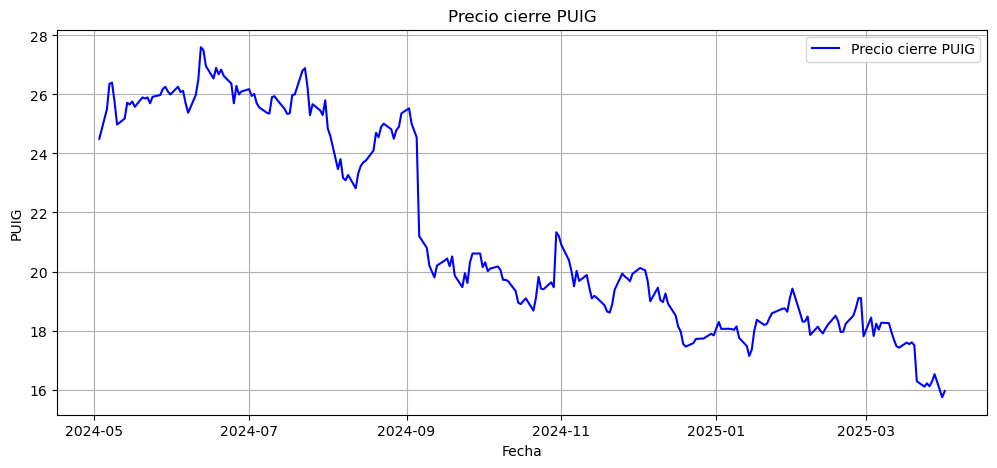

In [15]:
import matplotlib.pyplot as plt
# Graficar la serie temporal
plt.figure(figsize=(12, 5))
plt.plot(df_puig.index, df_puig['Precio_cierre'], label="Precio cierre PUIG", color='b')
plt.title("Precio cierre PUIG")
plt.xlabel("Fecha")
plt.ylabel("PUIG")
plt.legend()
plt.grid()
plt.show()

In [16]:
df_puig['year'] = df_puig.index.year                # Año
df_puig['month'] = df_puig.index.month              # Mes
df_puig['quarter'] = df_puig.index.quarter          # Trimestre
df_puig['day'] = df_puig.index.day                  # Día del mes
df_puig['day_of_week'] = df_puig.index.dayofweek    # Día de la semana (0 = Lunes, 6 = Domingo)
df_puig['week_of_year'] = df_puig.index.isocalendar().week  # Semana del año

In [17]:
df_puig['Precio_cierre_lag1'] = df_puig['Precio_cierre'].shift(1)
df_puig['year_lag1'] = df_puig['year'].shift(1)
df_puig['month_lag1'] = df_puig['month'].shift(1)
df_puig['quarter_lag1'] = df_puig['quarter'].shift(1)
df_puig['day_of_week_lag1'] = df_puig['day_of_week'].shift(1)
df_puig['week_of_year_lag1'] = df_puig['week_of_year'].shift(1)

In [18]:
# Media móvil con ventana de 60 días (2 meses)
df_puig['rolling_mean_60'] = df_puig['Precio_cierre'].shift(1).rolling(window=60).mean()
# Desviación estándar móvil con ventana de 60 días (2 meses)
df_puig['rolling_std_60'] = df_puig['Precio_cierre'].shift(1).rolling(window=60).std()

# Media móvil con ventana de 7 días (aproximadamente 1 semana)
df_puig['rolling_mean_7'] = df_puig['Precio_cierre'].shift(1).rolling(window=7).mean()
# Desviación estándar móvil con ventana de 7 días (aproximadamente 1 semana)
df_puig['rolling_std_7'] = df_puig['Precio_cierre'].shift(1).rolling(window=7).std()

# Media móvil con ventana de 30 días (aproximadamente 1 mes)
df_puig['rolling_mean_30'] = df_puig['Precio_cierre'].shift(1).rolling(window=30).mean()
# Desviación estándar móvil con ventana de 30 días (aproximadamente 1 mes)
df_puig['rolling_std_30'] = df_puig['Precio_cierre'].shift(1).rolling(window=30).std()


In [19]:
df_puig = df_puig.dropna()

In [21]:
 # Definir fecha de corte
fecha_test = '2025-01-01'

# División
train = df_puig[df_puig.index < fecha_test]
test = df_puig[df_puig.index >= fecha_test]

print(f"Train: {train.index.min().date()} → {train.index.max().date()}")
print(f"Test : {test.index.min().date()} → {test.index.max().date()}")

Train: 2024-07-26 → 2024-12-31
Test : 2025-01-02 → 2025-04-01


In [22]:
# Separar features (X) y target (y) en train
X_train, y_train = train.drop(columns=['Precio_cierre']), train['Precio_cierre']
# Separar features (X) y target (y) en test
X_test, y_test = test.drop(columns=['Precio_cierre']), test['Precio_cierre']

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import numpy as np

# Definir los modelos
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': xgb.XGBRegressor(),
    'SVR': SVR()
}

# Definir los hiperparámetros de cada modelo para GridSearchCV
param_grids = {
    'Linear Regression': {},
    'Decision Tree': {
        'max_depth': [5, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7]
    },
    'SVR': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }
}

In [25]:
# Función para hacer GridSearch y comparar RMSE
def evaluate_models(X_train, y_train, X_test, y_test, models, param_grids):
    best_model = None
    best_rmse = float('inf')
    best_model_name = ""

    for model_name, model in models.items():
        print(f"Entrenando {model_name}...")

        # Configurar GridSearchCV para cada modelo
        grid_search = GridSearchCV(estimator=model,
                                   param_grid=param_grids[model_name],
                                   scoring='neg_root_mean_squared_error',
                                   cv=3, # 3-fold cross-validation
                                   verbose=1)

        # Entrenar el modelo
        grid_search.fit(X_train, y_train)

        # Obtener el mejor modelo y su puntuación
        best_estimator = grid_search.best_estimator_
        best_score = -grid_search.best_score_  # Negativo porque usamos 'neg_root_mean_squared_error'

        print(f"Mejor RMSE para {model_name}: {best_score}")

        # Evaluar en el conjunto de prueba
        y_pred = best_estimator.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"RMSE en el conjunto de prueba para {model_name}: {rmse}")

        # Comparar el mejor RMSE
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = best_estimator
            best_model_name = model_name

    return best_model_name, best_model, best_rmse

# Suponiendo que ya tienes X_train, X_test, y_train, y_test listos
best_model_name, best_model, best_rmse = evaluate_models(X_train, y_train, X_test, y_test, models, param_grids)

print(f"El mejor modelo es: {best_model_name} con un RMSE de {best_rmse}")

Entrenando Linear Regression...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Mejor RMSE para Linear Regression: 10.252071289297023
RMSE en el conjunto de prueba para Linear Regression: 4.871326408741034
Entrenando Decision Tree...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Mejor RMSE para Decision Tree: 1.617336344811278
RMSE en el conjunto de prueba para Decision Tree: 0.8509924674199348
Entrenando Random Forest...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Mejor RMSE para Random Forest: 1.71946833951104
RMSE en el conjunto de prueba para Random Forest: 0.8860526273310327
Entrenando Gradient Boosting...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Mejor RMSE para Gradient Boosting: 1.7844433699686046
RMSE en el conjunto de prueba para Gradient Boosting: 0.7422119345496849
Entrenando XGBoost...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Mejor RMSE para XGBoost: 1.7746800716071622
RMSE en el conjunto de p